In [1]:
import os
import sys

%matplotlib inline
import time
import pylab as pl
from IPython import display

import numpy as np
import argparse
import h5py
import math
import time
import logging
import matplotlib.pyplot as plt
import torchvision
from sklearn import metrics
import _pickle as cPickle
import shutil

from tqdm import tqdm_notebook as tqdm
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from models import CNN_two, Cnn6
from data_generator import medleyDataset, medleyDataset_logmel, medleyDataset_audio

from losses import get_loss_func
from sklearn.metrics import roc_auc_score

In [2]:
def save_checkpoint(state, is_best, directory, filename='checkpoint.pth.tar'):
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    filename = os.path.join(directory, filename)
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, os.path.join(directory,'model_best.pth.tar'))

In [3]:
# scatter_type = '6_8_33075'
scatter_type = '9_8_132300'

# train_dir = '/home/laura/MedleyDB/processed/'+scatter_type+'/train'
# val_dir = '/home/laura/MedleyDB/processed/'+scatter_type+'/val'
train_dir = '/home/laura/MedleyDB/processed/spec/train'
val_dir = '/home/laura/MedleyDB/processed/spec/val'

time_steps = 827
freq_bins = 64

train_dataset = medleyDataset_logmel(train_dir, time_steps, freq_bins, 18)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=16,
    num_workers=os.cpu_count(),
    shuffle=True,
    drop_last=True
)

val_dataset = medleyDataset_logmel(val_dir, time_steps, freq_bins, 18)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=1,
    num_workers=os.cpu_count(),
    shuffle=True
)

print(len(train_dataset))
print(len(val_dataset))

2209
685


In [4]:
model = Cnn6(classes_num=18, time_steps=827, freq_bins=64)

# model = CNN_two(classes_num=18)

model.cuda()

loss_func = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

In [5]:
sum(p.numel() for p in model.parameters())

4576338

In [6]:
losses_train = []
losses_val = []
epoch = 0

early_stop = False

while not early_stop:
    running_loss = 0.0
    
    for batch_data_dict in tqdm(train_loader):
        
        # batch_input1 = batch_data_dict['order1'].cuda()
        # batch_input2 = batch_data_dict['order2'].cuda()
        batch_input = batch_data_dict['logmel'].cuda()
        batch_target = batch_data_dict['target'].cuda()

        # batch_output_dict = model(batch_input1, batch_input2)
        batch_output_dict = model(batch_input)
        batch_target_dict = {'target': batch_target}
        
        loss = loss_func(batch_output_dict['clipwise_output'], batch_target_dict['target'])

        # Backward
        loss.backward()
        running_loss += loss.item() * train_loader.batch_size
        
        optimizer.step()
        optimizer.zero_grad()
    
    epoch_loss = running_loss / len(train_dataset)
    losses_train.append(epoch_loss)

    display.clear_output(wait=True)
    print('Epoch', epoch, ',  Train loss:', epoch_loss, end='\r')
    model.eval()

    val_loss = 0.0

    for batch_data_dict in val_loader:

        # batch_input1 = batch_data_dict['order1'].cuda()
        # batch_input2 = batch_data_dict['order2'].cuda()
        batch_input = batch_data_dict['logmel'].cuda()
        batch_target = batch_data_dict['target'].cuda()

        # batch_output_dict = model(batch_input1, batch_input2)
        batch_output_dict = model(batch_input)
        batch_target_dict = {'target': batch_target}

        loss = loss_func(batch_output_dict['clipwise_output'], batch_target_dict['target'])

        val_loss += loss.item() * val_loader.batch_size

    val_loss = val_loss / len(val_dataset)

    losses_val.append(val_loss)

    if epoch > 50 and losses_val[-1] > min(losses_val):
        early_stop = True

    model.train()

    # pl.plot(losses_train)
    # pl.plot(losses_val)
    # display.clear_output(wait=True)
    # display.display(pl.gcf())
    # time.sleep(0.1)

    epoch += 1

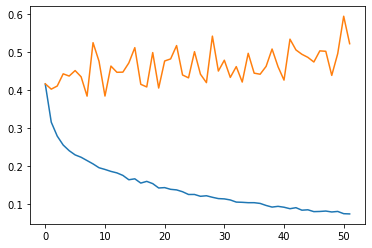

In [7]:
plt.plot(losses_train)
plt.plot(losses_val)
plt.show()

In [8]:
print(min(losses_train))

0.07367265977272355


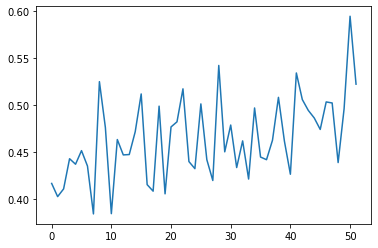

In [9]:
plt.plot(losses_val)

In [10]:
print(min(losses_val))
print(np.argmin(np.array(losses_val)))

0.3838828217374147
7


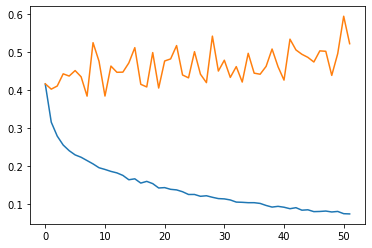

In [11]:
plt.plot(losses_train)
plt.plot(losses_val)
plt.show()